In [192]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
np.random.seed(0)
import csv
import matplotlib.pyplot as plt

In [2]:
# Returns data tensors for images and labels (binary values 0 and 1)
def load_data(filepath='train.csv'):
    data = pd.read_csv(filepath)
    labels = data['label'].values
    pixels = data.drop('label', axis=1).values
    
    # Convert to binary (0 or 1)
    pixels = (pixels > 127).astype(np.float32)
    
    # Convert to PyTorch tensors
    pixels_tensor = torch.FloatTensor(pixels)
    labels_tensor = torch.LongTensor(labels)
    
    return pixels_tensor, labels_tensor

In [3]:
def split_data(X, y, train_ratio=0.8):
    """
    Split the data into training and testing sets.

    Parameters:
        X (torch.Tensor): The feature tensor (pixels).
        y (torch.Tensor): The label tensor.
        train_ratio (float): The proportion of data to use for training.

    Returns:
        X_train, X_test, y_train, y_test (torch.Tensor): Split datasets.
    """
    # Calculate the split index
    total_samples = X.shape[0]
    train_size = int(total_samples * train_ratio)
    test_size = total_samples - train_size

    # Randomly split the dataset
    train_indices = torch.randperm(total_samples)[:train_size]
    test_indices = torch.randperm(total_samples)[train_size:]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


In [9]:
# Define the ScalableLinear layer without bias
class ScalableLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features, dtype=torch.float32))  # Initialize weights

    def forward(self, x):
        return x @ self.weight

    def scale_weights(self, target_min, target_max):
        """Scale the weights of the layer to a desired integer range."""
        with torch.no_grad():
            # Get the min and max values of the layer's weights
            weight_min = self.weight.min()
            weight_max = self.weight.max()

            # Compute scaling factor
            scale = (target_max - target_min) / (weight_max - weight_min)
            zero_point = target_min - weight_min * scale

            # Apply scaling to weights
            quantized_weights = torch.round(self.weight * scale + zero_point)

            # Clip to the target range (make sure no value goes outside the desired range)
            quantized_weights = torch.clamp(quantized_weights, target_min, target_max)

            # Update weights with quantized values
            self.weight.data = quantized_weights


 # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Define the neural network with scalable layers
class ScalableNet(nn.Module):
    def __init__(self, input_size=784):
        super().__init__()
        self.layer1 = ScalableLinear(input_size, 64)
        self.layer2 = ScalableLinear(64, 64)
        self.layer3 = ScalableLinear(64, 32)
        self.layer4 = ScalableLinear(32, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        return x

    # Helper function that scales weights directly
    def scale_weights(self, target_min, target_max):
        """Scale weights for all layers."""
        self.layer1.scale_weights(target_min, target_max)
        self.layer2.scale_weights(target_min, target_max)
        self.layer3.scale_weights(target_min, target_max)
        self.layer4.scale_weights(target_min, target_max)

In [10]:
# Entry point in training loop that scales our weights
def gradual_scale_weights(model, initial_target_min, initial_target_max, final_target_min, final_target_max, step_size, epoch, max_epochs):
    """
    Gradually scale the weights of each layer after each epoch.
    """
    # Compute the scaling range for this epoch based on the progress in training
    scale_min = initial_target_min + (final_target_min - initial_target_min) * (epoch / max_epochs)
    scale_max = initial_target_max + (final_target_max - initial_target_max) * (epoch / max_epochs)

    # Apply gradual scaling to each layer
    model.scale_weights(target_min=int(scale_min), target_max=int(scale_max))

In [193]:
# Load the data
X, y = load_data('train.csv')

# Split into training and testing datasets
X_train, X_test, y_train, y_test = split_data(X, y, train_ratio=0.9)

print(f"Training set size: {X_train.size(0)} samples")
print(f"Testing set size: {X_test.size(0)} samples")

Training set size: 37800 samples
Testing set size: 4200 samples


In [155]:
# Train the model
model = ScalableNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
batch_size = 1024
epochs=10
n_batches = n_samples // batch_size
initial_target_min= -128
initial_target_max= 127
final_target_min= -64
final_target_max= 64
step_size= 0.1
n_samples = X_train.shape[0]
n_batches = n_samples // batch_size

Training set size: 37800 samples
Testing set size: 4200 samples


In [186]:
# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_X = X_train[start_idx:end_idx]
        batch_y = y_train[start_idx:end_idx]
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pas
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / n_samples
    accuracy = correct / n_samples
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Scale the weights using 
    # Gradual weight scaling after each epoch
    gradual_scale_weights(model, initial_target_min, initial_target_max, final_target_min, final_target_max, step_size, epoch, epochs)

Epoch [1/10], Loss: 7929.4462, Accuracy: 0.8280
Epoch [2/10], Loss: 70640.1103, Accuracy: 0.8287
Epoch [3/10], Loss: 53799.1818, Accuracy: 0.8331
Epoch [4/10], Loss: 41673.6290, Accuracy: 0.8351
Epoch [5/10], Loss: 40392.3432, Accuracy: 0.8372
Epoch [6/10], Loss: 32899.6534, Accuracy: 0.8075
Epoch [7/10], Loss: 20795.5762, Accuracy: 0.8268
Epoch [8/10], Loss: 27728.4615, Accuracy: 0.7980
Epoch [9/10], Loss: 17922.8936, Accuracy: 0.7774
Epoch [10/10], Loss: 19985.3653, Accuracy: 0.7736


In [153]:
# Check min and max values before and after scaling
print("Before scaling:")
for layer in model.children():
    if isinstance(layer, ScalableLinear):
        print(f"Layer weights min: {layer.weight.min().item()}, max: {layer.weight.max().item()}")

# # Apply scaling
# model.scale_weights(target_min=-, target_max=127)

Before scaling:
Layer weights min: -70.0, max: 70.0
Layer weights min: -70.0, max: 70.0
Layer weights min: -70.0, max: 70.0
Layer weights min: -70.0, max: 70.0


In [190]:
# Test the model after scaling the weights
def test_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate on the test set
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
        
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_test).sum().item()
        accuracy = correct / y_test.size(0)
        
    print(f"Test Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")
    
# Assuming you have the test set X_test and y_test available
# Run the evaluation after scaling the weights
model.scale_weights(target_min=-32, target_max=32)

# Test the model after scaling
test_model(model, X_test, y_test)

Test Loss: 536441.6875, Test Accuracy: 0.8033


In [188]:
for i, layer in enumerate(model.children()):
        if isinstance(layer, ScalableLinear):  # Ensure that the layer is of type ScalableLinear
            print(f"Layer {i+1} Weights:\n", layer.weight.data)
            print(layer.weight.data)
            print(layer.weight.shape)

Layer 1 Weights:
 tensor([[ -5.,  -5., -10.,  ..., -10.,  -3.,   3.],
        [ -3.,  -5.,   0.,  ...,   5.,   0.,  -3.],
        [  0., -10.,   0.,  ...,   5.,   3.,   0.],
        ...,
        [  3.,  -3.,  10.,  ...,  -8., -10.,  -3.],
        [  0.,  -3.,   0.,  ...,   0.,  10.,  10.],
        [ -3., -15.,   5.,  ...,  -3.,   3.,   3.]])
tensor([[ -5.,  -5., -10.,  ..., -10.,  -3.,   3.],
        [ -3.,  -5.,   0.,  ...,   5.,   0.,  -3.],
        [  0., -10.,   0.,  ...,   5.,   3.,   0.],
        ...,
        [  3.,  -3.,  10.,  ...,  -8., -10.,  -3.],
        [  0.,  -3.,   0.,  ...,   0.,  10.,  10.],
        [ -3., -15.,   5.,  ...,  -3.,   3.,   3.]])
torch.Size([784, 64])
Layer 2 Weights:
 tensor([[  0., -10.,   5.,  ..., -19.,   5.,  -5.],
        [-15.,  -0., -15.,  ..., -15., -15.,   0.],
        [  0.,  -5., -15.,  ..., -10.,  -0., -10.],
        ...,
        [ 15., -10.,  -5.,  ...,  -5.,   0.,   0.],
        [-10.,   3.,  17.,  ...,  15.,  26.,   5.],
        [-15.,  -

In [191]:
def save_weights_as_hex(model):
    weight_matrices = [model.layer1.weight.data, model.layer2.weight.data, model.layer3.weight.data, model.layer4.weight.data]

    for idx, weight_matrix in enumerate(weight_matrices, start=1):
        # Flatten weight matrix
        flattened_weights = weight_matrix.flatten().cpu().numpy()
        
        # Open corresponding file for saving weights
        with open(f'matrix{idx}.mif', 'w') as file:
            for weight in flattened_weights:
                # Convert directly to integer
                int_weight = int(weight.item())
                # Format as 8-digit unsigned hexadecimal
                hex_weight = f"{int_weight & 0xFFFFFFFF:08X}"
                # Write only the value
                file.write(f"{hex_weight}\n")
save_weights_as_hex(model)

In [195]:
def test_and_visualize(model, X_test, y_test, index):
    """
    Tests the model on a single sample from X_test and visualizes the digit image.
    
    Parameters:
    model (ScalableNet): The trained model to be tested.
    X_test (torch.Tensor): The test set features.
    y_test (torch.Tensor): The test set labels.
    index (int): The index of the sample to visualize and predict.
    """
    model.eval()  # Set the model to evaluation mode

    # Extract the sample at the specified index
    sample = X_test[index].unsqueeze(0)  # Shape (1, 784)
    label = y_test[index].item()

    # Predict the label
    with torch.no_grad():
        output = model(sample)
        print(output)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.item()

    # Visualize the image
    visualize_digit(sample.numpy().flatten())
    
    # Print the actual and predicted labels
    print(f"Actual Label: {label}, Predicted Label: {predicted_label}")

def visualize_digit(tensor):
    """
    Visualize a digit represented by a (1, 784) tensor.

    Parameters:
    tensor (numpy.ndarray): A (1, 784) numpy array representing the digit.
    """
    # Reshape the tensor to a 28x28 matrix
    digit_image = tensor.reshape(28, 28)
    
    # Plot the image
    plt.imshow(digit_image, cmap='gray')
    plt.axis('off')
    plt.show()

tensor([[20710928., -8142275.,  5900262.,  6699273.,  2516099.,  3886994.,
          4830562.,  9627337., 12788586.,  9228000.]])


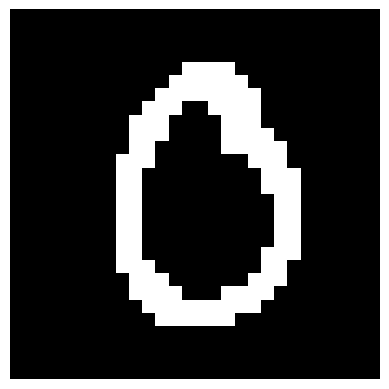

Actual Label: 0, Predicted Label: 0


In [197]:
# Usage Example:
# Assuming X_test and y_test are torch tensors
# index = 5  # Example index you want to test and visualize
idx = 3
test_and_visualize(model, X_test, y_test, index=idx)